# Tutorial 1, Alignment of simulated data

In [1]:
import sys
sys.path.append(r"/home/wangheqi/PycharmProject/")

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import torch

import matplotlib.pyplot as plt
import spcoral

### Prepare the dataset

Download this data from [google drive](https://drive.google.com/file/d/1LaYZa7pk9vgLdaW5PgIW4QB6NBhLxLuK/view?usp=sharing).

There are a total of four types of patterns available here('enhanced', 'enhanced2', 'layers', 'island').

Each pattern have 5 different samples.

In [2]:
pattern = 'layers'
num = '1'

adata_rna = sc.read_h5ad(f'/home/wangheqi/PycharmProject/data/alignment_sim/RNA_sim/{pattern}/adata_rna_trans_sim{num}.h5ad')
adata_atac = sc.read_h5ad(f'/home/wangheqi/PycharmProject/data/alignment_sim/ATAC_sim/{pattern}/adata_atac_sim{num}.h5ad')

In [3]:
adata_atac.var_names = ['atac' + i for i in adata_atac.var_names.tolist()]
adata_rna.obsm['spatial_raw'] = adata_rna.obsm['spatial']
adata_rna.obsm['spatial'] = adata_rna.obsm['spatial_transformed']

Visualization of cell type of the pair multi-omics data.

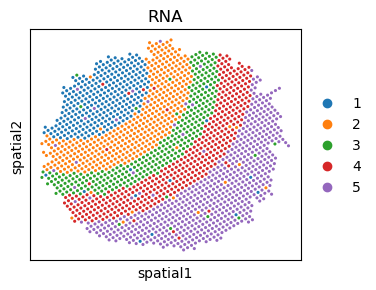

In [4]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.5, 3))
sc.pl.embedding(adata_rna, basis='spatial', color='cell.type', ax=ax, s=20, title='RNA')

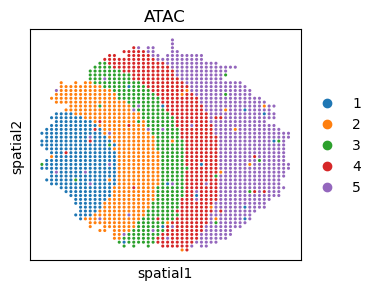

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 3))
sc.pl.embedding(adata_atac, basis='spatial', color='cell.type', ax=ax, s=20, title='ATAC')

### Preprocess multi-omics data

In [6]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_rna)
# Logarithmize the data
sc.pp.log1p(adata_rna)
sc.pp.scale(adata_rna)

In [7]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_atac)
# Logarithmize the data
sc.pp.log1p(adata_atac)
sc.pp.scale(adata_atac)

In [8]:
# selected preprocessed data as the input
adata_rna.obsm['feat'] = adata_rna.X
adata_atac.obsm['feat'] = adata_atac.X

### Model training

In [9]:
Model = spcoral.model.regist_model(
    adata_omics1 = adata_rna,
    adata_omics2 = adata_atac,
    graph_method = 'radius',
    radius_spatial_omics1 = 1.1,
    radius_spatial_omics2 = 1.1,
    alpha = 0.1,
    epochs=200,
    random_seed=2030,
    device = torch.device('cpu')
)

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


In [10]:
adata_rna, adata_atac, loss_list = Model.train()
adata_rna, registering_parameters = spcoral.model.registration(
    adata_rna, adata_atac, n_iter=0, beta=0.9, method='rigid'
)

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


Training: 100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.24it/s]


The number of anchors is 2000


### Visualization of the output

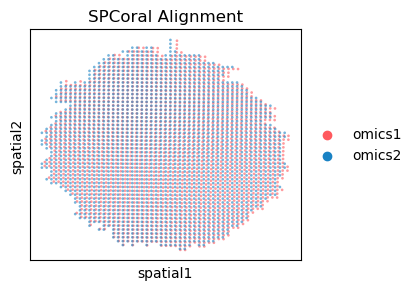

In [11]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.5, 3))

spcoral.plot.show_cross_align(
    adata_rna, adata_atac,
    omics1_use_obsm='spatial_reg', 
    omics2_use_obsm='spatial',
    ax=ax,
    size_omics1=15,
    size_omics2=15,
    alpha_omics1=0.6,
    alpha_omics2=0.6,
    title='SPCoral Alignment',
)

dataset1: 5 cell types; dataset2: 5 cell types; 
                    Total :5 celltypes; Overlap: 5 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 2000
{'color_type': 'categorical', 'palette': ['#f9c80e', '#f86624', '#ea3546', '#662e9b', '#43bccd']}


<Axes3D: >

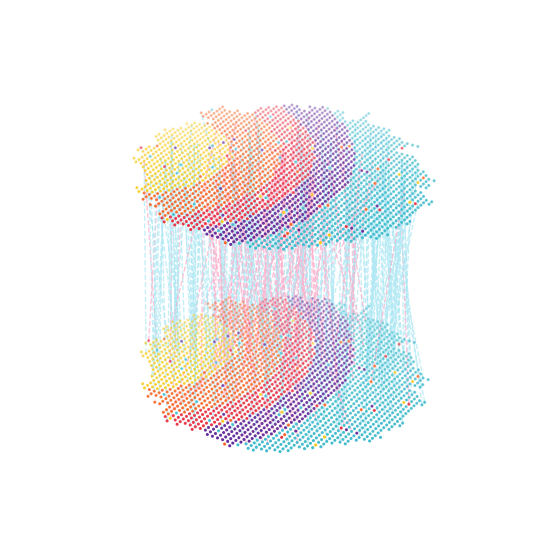

In [12]:
%matplotlib inline

spcoral.plot.show_cross_align_3D(
    adata_rna, adata_atac, registering_parameters, color_based='cell.type',
    omics1_use_obsm='spatial_reg', omics2_use_obsm='spatial', line_width=1, show=False
)